# Style Transfer (Jonathan Witacker)

[YT video timestamp](https://youtu.be/PdNHkTLU2oQ?t=1236)

# Setup

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

Using cuda


In [ ]:
# Image URLs for demos. Change as desired.
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

# Loading Images

In [ ]:
def download_image(url):
    """Download image and decode into a bitmap"""
    imgb = fc.urlread(url, decode=False) 
    # instead of using PIL, we directly use the torchvision decoder.
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

content_im.shape: torch.Size([3, 256, 256])


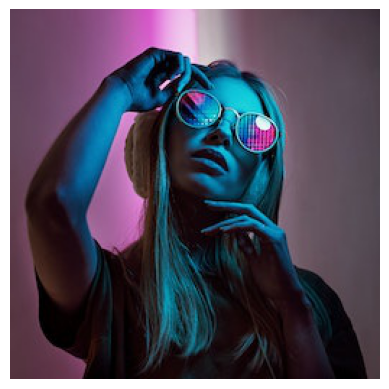

In [ ]:
content_im = download_image(face_url).to(def_device)
print('content_im.shape:', content_im.shape)
show_image(content_im);

In [ ]:
content_im.min(),content_im.max() # Check bounds

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

# Optimizing Images

First example is to optimize one noisy image and transform it into a target image (the lady with glassed above)

We only have one image, not a dataset. But we want to optimize one image in many steps.

So we create a dummy dataset that does not return data, but allows us to "hack" the learner to optimize our single image, while it is "believing" it receives many images.

`LengthDataset` class simulate what pytorch expects from a dataset, but returning always (0, 0)

In [ ]:
class LengthDataset():
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1), # Train
                       DataLoader(LengthDataset(1), batch_size=1))      # Valid (length 1)

In [ ]:
for batch in get_dummy_dls(10).train:
    print(batch)

[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]
[tensor([0]), tensor([0])]


In [ ]:
for batch in get_dummy_dls(10).valid:
    print(batch)

[tensor([0]), tensor([0])]


The model (TensorModel) has as parameters the tensor we pass in. No layer, ... just a tensor to optimize

In [ ]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): 
        """Dummy forward pass to conform with what the learner expect"""
        return self.t

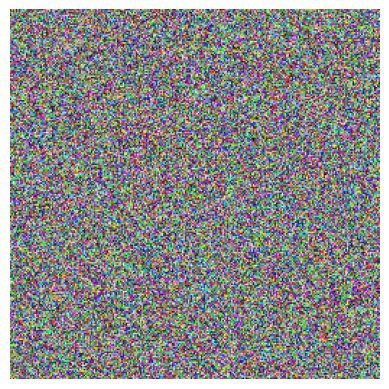

In [ ]:
model = TensorModel(torch.rand_like(content_im))
show_image(model());

We can see that the parameters are the image pixels or shape (3,256,256)

In [ ]:
[p.shape for p in model.parameters()]

[torch.Size([3, 256, 256])]

By setting the image tensor as the parameters, we can optimize it with backprop (t requires grad)

In [ ]:
model.t.requires_grad

True

In [ ]:
class ImageOptCB(TrainCB):
    def predict(self, learn): 
        learn.preds = learn.model()
    def get_loss(self, learn): 
        """Overwrite the loss function so that it does not need a target"""
        learn.loss = learn.loss_func(learn.preds)

In [ ]:
# im is the noisy image which we are making evolve toward the target
# content_im is the target image

def loss_fn_mse(im):
    return F.mse_loss(im, content_im)

model = TensorModel(torch.rand_like(content_im))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

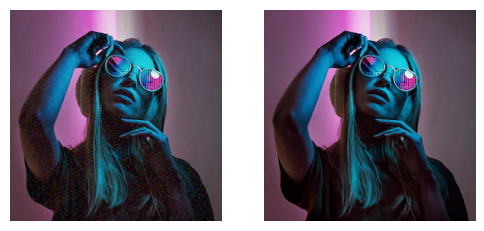

In [ ]:
# Result (left) vs target image (right):
show_images([learn.model().clip(0, 1), content_im]);

## Viewing progress

It would be great if we could see what is happening over time. You could save individual images and turn them into a video, but for quick feedback we can also log images every few iterations and display them in a grid in `after_fit`:

In [ ]:
class ImageLogCB(Callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): store_attr(); self.images=[]; self.i=0
    def after_batch(self, learn): 
        if self.i%self.log_every == 0: self.images.append(to_cpu(learn.preds.clip(0, 1)))
        self.i += 1
    def after_fit(self, learn): show_images(self.images)

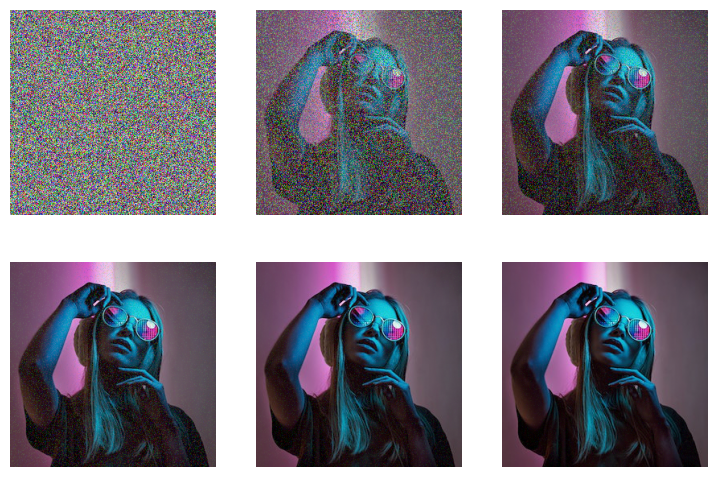

In [ ]:
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

## Getting Features from VGG16

We're going to peek inside a small CNN and extract the outputs of different layers.

Features in CNN layers: [distil.pub post](https://distill.pub/2017/feature-visualization/)

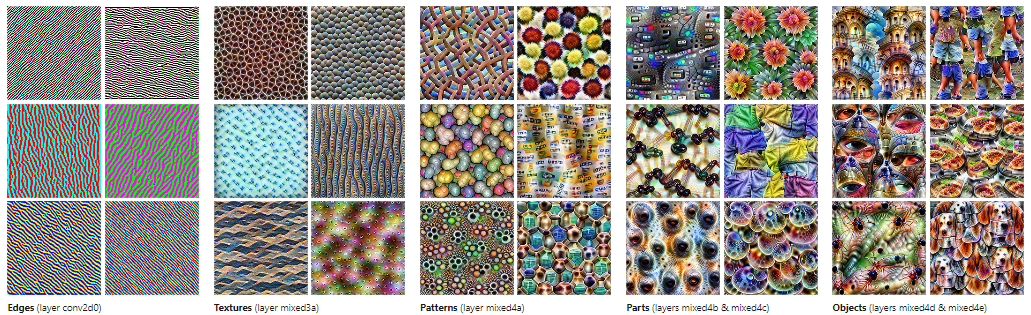

### Load VGG network

![vgg diag](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

Interesting comment by JH [(timestamp)](https://youtu.be/PdNHkTLU2oQ?t=2145)

`7 x 7 x 512` is flattened into `1 x 1 x 4096`. Nowadays, we use adaptive or global pooling to get down to `1 x 1 x 512` because the last layer from `4096` -> `1000` is a huge dense layer which takes a lot of memory. 

In [ ]:
print(timm.list_models('*vgg*'))

['repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [ ]:
# Load the model whithout the head
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features

In [ ]:
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

### Normalize Images

This model expacts images normalized with the same stats as those used during training, which in this case requires the stats of the ImageNet dataset. Previously we were working with single-channel images, and so normalizing was pretty straightforward. With three channels, we need to think a bit more about shapes and boradcasting rules:

In [ ]:
imagenet_mean = tensor([0.485, 0.456, 0.406])
imagenet_std = tensor([0.229, 0.224, 0.225])

In [ ]:
# Try 1 (won't work):
# (content_im - imagenet_mean) / imagenet_std

In [ ]:
imagenet_mean.shape

torch.Size([3])

In [ ]:
content_im.shape

torch.Size([3, 256, 256])

In [ ]:
imagenet_mean[:,None,None].shape

torch.Size([3, 1, 1])

In [ ]:
# Try 2:
def normalize(im):
    imagenet_mean = tensor([0.485, 0.456, 0.406])[:,None,None].to(im.device)
    imagenet_std = tensor([0.229, 0.224, 0.225])[:,None,None].to(im.device)
    return (im - imagenet_mean) / imagenet_std

In [ ]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

In [ ]:
normalize(content_im).mean(dim=(1, 2))

tensor([-0.9736, -0.9623, -0.4226], device='cuda:0')

In [ ]:
# And with torchvision transforms:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

### Get intermediate representations, take 1:

We want to feed some data through the network, storing thr outputs of different layers. Here's one way to do this:

In [ ]:
def calc_features(imgs, target_layers=(18, 25)): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

In [ ]:
# Testing it out to see the shapes of the resulting feature maps:
feats = calc_features(content_im)
[f.shape for f in feats]

[torch.Size([512, 32, 32]), torch.Size([512, 16, 16])]

512 channels/feature maps of size 32 x 32 and size 16 x 16

In [ ]:
# Homework: Can you do this using hooks?

### What's the point?

You may remember us looking at https://distill.pub/2017/feature-visualization/ and talking about how deep CNNs 'learn' to classify images. Early layers tend to capture gradients and textures, while later layers tend towards more complex types of feature. We're going to exploit this hierarchy for artistic purposes, but being able to choose what kind of feature you'd like to use when comparing images has a number of other useful applications. 

# Optimizing an Image with Content Loss

To start with, let's try optimizing an image by comparing it's features (from two later layers) with those from the target image. If our theory is right, we should see the structure of the target emerge from the noise without necessarily seeing a perfect re-production of the target like we did in the previous MSE loss example.

In [ ]:
class ContentLossToTarget():
    def __init__(self, target_im, target_layers=(18, 25)):
        """Store the features in target layers for the target image"""
        fc.store_attr()
        with torch.no_grad():
            self.target_features = calc_features(target_im, target_layers)
    def __call__(self, input_im): 
        """Evaluate MSE between features in target layers for target img and features same layers for new img"""
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_features(input_im, self.target_layers), self.target_features))

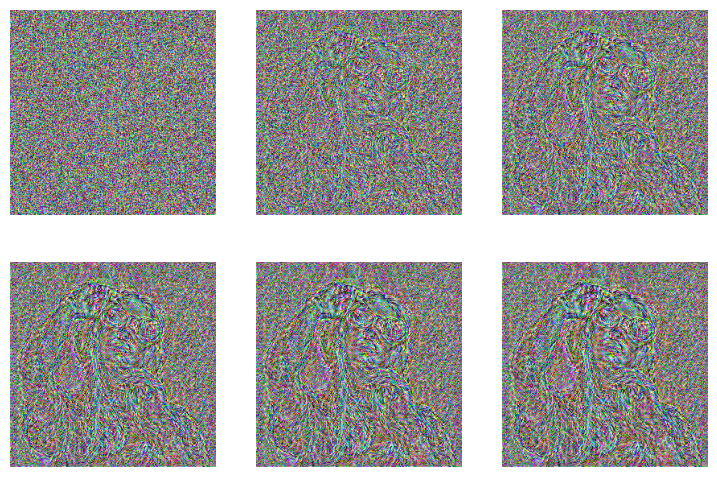

In [ ]:
loss_function_perceptual = ContentLossToTarget(content_im)
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

- One issue is that in the optimized image is not bound to the normal 0-1 range for pixel intensity. May want to have a tanh or sigmoid to constrain the optimized image
- by looking at deeper layers, the model does not look at color any longer

**Choosing the layers determines the kind of features that are important:**

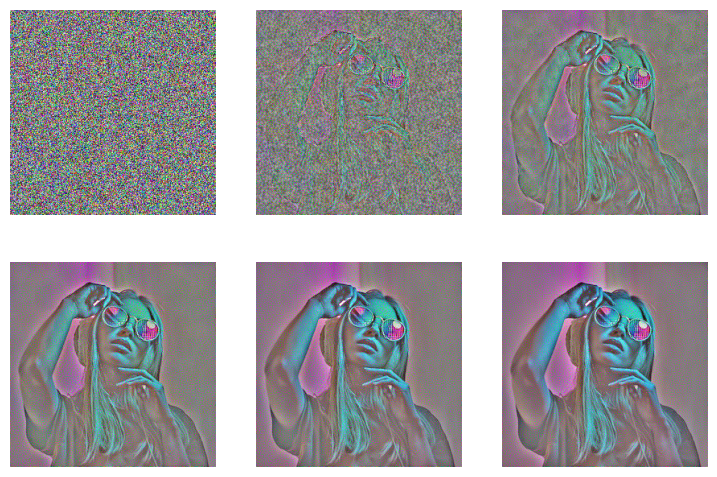

In [ ]:
loss_function_perceptual = ContentLossToTarget(content_im, target_layers=(1, 6))
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

- Here lower level feature (color, ...) is better preserved because we are looking at earlier layers

# Style Loss with Gram Matrix

So, we know how to extract feature maps. The next thing we'd like to do is find a way to capture the **style** of an input image, based on those early layers and the kinds of textural feature that they learn. Unfortunately, we can't just compare the feature maps from some early layers since these 'maps' encode information spatially - which we don't want!

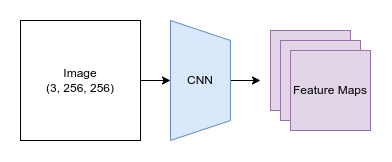

So, we need a way to measure what **kinds** of style features are present, and ideally which kinds occur together, without worrying about **where** these features occur in the image. 

Enter something called the Gram Matrix. The idea here is that we'll measure the **correlation** between features. Given a feature map with `f` features in an `h` x `w` grid, we'll flatten out the spatial component and then for every feature we'll take the dot product of that row with itself, giving an `f` x `f` matrix as the result. Each entry in this matrix quantifies how correlated the relevant pair of features are and how frequently they occur - exactly what we want. In this diagram each feature is represented as a colored dot.

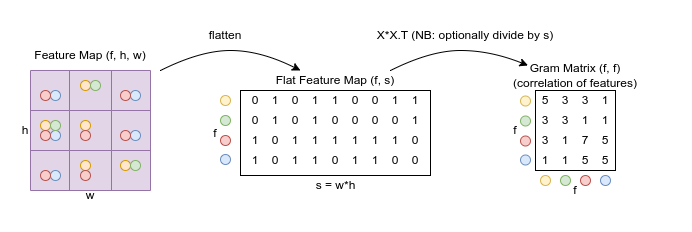

Ideas *Image Style Transfer Using Convolutional Neural Networks* (Gatys et al., 2016) and *A Neural Algorithm of Artistic Style* (Gatys et al., 2015) [arxiv](https://arxiv.org/abs/1508.06576)

Re-creating the diagram operations in code:

In [ ]:
t = tensor([[0, 1, 0, 1, 1, 0, 0, 1, 1],
            [0, 1, 0, 1, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0],
            [1, 0, 1, 1, 0, 1, 1, 0, 0]])

In [ ]:
torch.einsum('fs, gs -> fg', t, t)

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

In [ ]:
t.matmul(t.T) # Alternate approach

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

### Trying it out

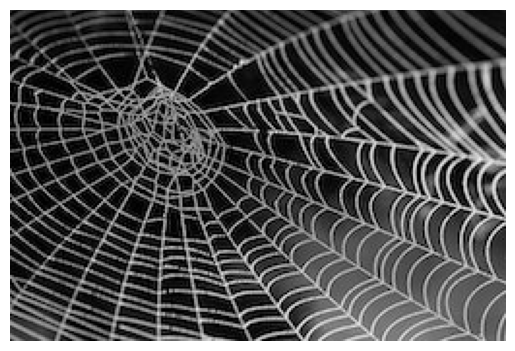

In [ ]:
style_im = download_image(spiderweb_url).to(def_device)
show_image(style_im);

In [ ]:
def calc_grams(img, target_layers=(1, 6, 11, 18, 25)):
    # calculate the gram matrix and scale it to take into account the size of the image (s = w . h)
    return L(torch.einsum('chw, dhw -> cd', x, x) / (x.shape[-2]*x.shape[-1]) # 'bchw, bdhw -> bcd' if batched
            for x in calc_features(img, target_layers))

In [ ]:
style_grams = calc_grams(style_im)

In [ ]:
[g.shape for g in style_grams] # The gram matrices for features from different layers

[torch.Size([64, 64]),
 torch.Size([128, 128]),
 torch.Size([256, 256]),
 torch.Size([512, 512]),
 torch.Size([512, 512])]

In [ ]:
style_grams.attrgot('shape') # The magic of fastcore's L

(#5) [torch.Size([64, 64]),torch.Size([128, 128]),torch.Size([256, 256]),torch.Size([512, 512]),torch.Size([512, 512])]

In [ ]:
class StyleLossToTarget():
    def __init__(self, target_im, target_layers=(1, 6, 11, 18, 25)):
        fc.store_attr()
        with torch.no_grad(): 
            self.target_grams = calc_grams(target_im, target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_grams(input_im, self.target_layers), self.target_grams))

In [ ]:
style_loss = StyleLossToTarget(style_im)

In [ ]:
style_loss(content_im)

tensor(501.6353, device='cuda:0', grad_fn=<AddBackward0>)

Our content image has a high loss compared to the spider web. Normal as it does not look at all like a web.

## Style Transfer

Here we start from the content image, not the noise image, as we want to transfer style from target image (spider web) to the content image

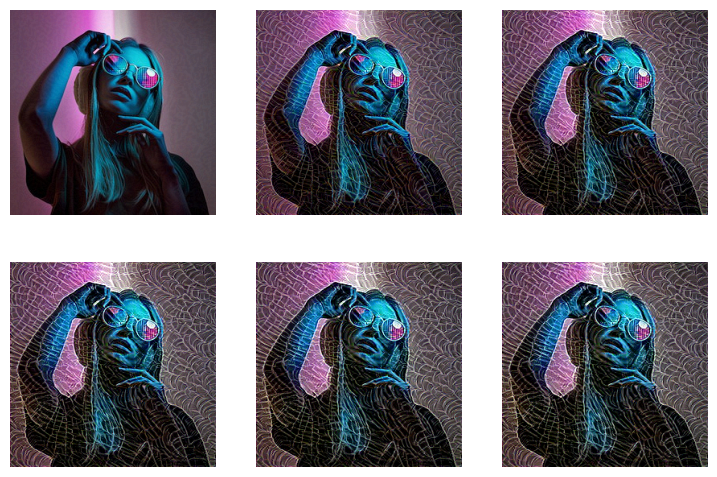

In [ ]:
model = TensorModel(content_im) # Start from content image
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im)
def combined_loss(x):
    return style_loss(x) + content_loss(x)
learn = Learner(model, get_dummy_dls(150), combined_loss, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

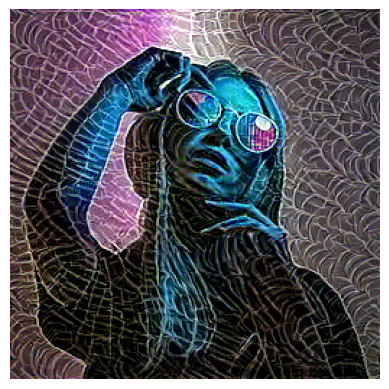

In [ ]:
show_image(learn.model().clip(0, 1)); # View the final result

And trying with random starting image, weighting the style loss lower, using different layers:

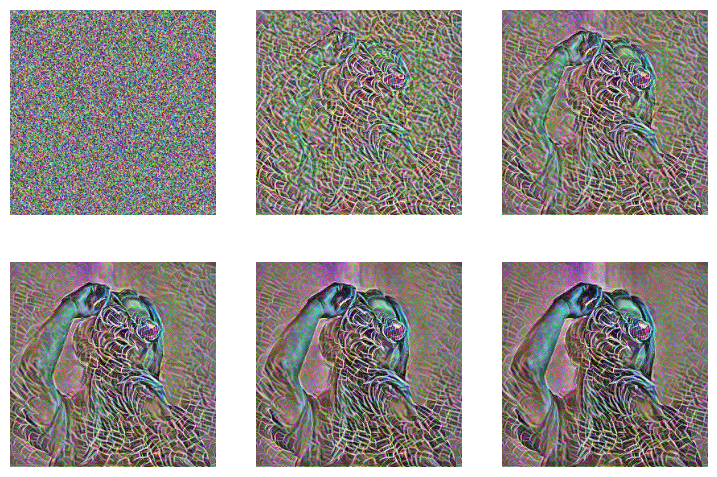

In [ ]:
model = TensorModel(torch.rand_like(content_im))
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im, target_layers=(6, 18, 25))
def combined_loss(x):
    return style_loss(x) * 0.2 + content_loss(x)
learn = Learner(model, get_dummy_dls(300), combined_loss, lr=5e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(60)])

## For Comparison: non-miniai version

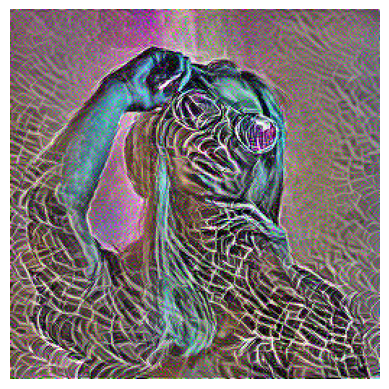

In [ ]:
# The image to be optimized
im = torch.rand(3, 256, 256).to(def_device)
im.requires_grad = True

# Set up the optimizer
opt = torch.optim.Adam([im], lr=5e-2)

# Define the loss function
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im, target_layers=[6, 18, 25])
def combined_loss(x):
    return style_loss(x) * 0.2 + content_loss(x)

# Optimization loop
for i in range(300):
    loss = combined_loss(im)
    loss.backward()
    opt.step()
    opt.zero_grad()
    
# Show the result
show_image(im.clip(0, 1));

What do you think are some pros and cons? How would this look once we start displaying progress, testing different configurations and so on?